In [1]:
import django, os, sys, time, resource, re, gc, shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from django.db.models import Count, Avg, F, Sum
import math

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *


In [2]:
alldocs = Doc.objects.filter(
    query__project=2,
    query__qtype='MN',
    query__upload_link__category__project=2,
    query__upload_link__category__gt=1,
    wosarticle__ti__isnull=False
)

print(alldocs.count())



260


In [3]:
found = 0
for d in alldocs:
    print(repr(d.wosarticle.ti))
    sdocs = Doc.objects.filter(
        title=d.wosarticle.ti.replace('\r','').replace('\n','')
    ).exclude(id=d.id)
    if sdocs.count() > 0:
        print(sdocs)
        print(sdocs.first().title)
        found +=1
        
print("FOUND {} docs in database".format(found))

'A life cycle assessment approach to quantifying greenhouse gas emissions from land-use change for beef production in eastern Australia'
<QuerySet [<Doc: WOS:000354566700005>]>
A life cycle assessment approach to quantifying greenhouse gas emissions from land-use change for beef production in eastern Australia
'THE DEPTH DISTRIBUTION OF SOIL ORGANIC CARBON IN RELATION TO LAND USE AND MANAGEMENT AND THE POTENTIAL OF CARBON SEQUESTRATION IN SUBSOIL HORIZONS'
'Strengthening the soil organic carbon pool by increasing contributions from recalcitrant aliphatic bio(macro)molecules'
<QuerySet [<Doc: WOS:000250702100001>]>
Strengthening the soil organic carbon pool by increasing contributions from recalcitrant aliphatic bio(macro)molecules
'Water Footprint and Land Requirement of Solar Thermochemical Jet-Fuel Production'
'Microbial Electrolytic Carbon Capture for Carbon Negative and Energy Positive Wastewater Treatment'
<QuerySet [<Doc: WOS:000357840300083>]>
Microbial Electrolytic Carbon Captu

In [4]:
ems = EmailTokens.objects.filter(sent=True,category__gt=1,category__project=2)


for em in ems.iterator():
    em.valid_docs = Doc.objects.filter(query__upload_link=em,wosarticle__ti__isnull=False).distinct().count()
    em.save()
    
    


df = pd.DataFrame.from_dict(list(ems.values()))



df.head()

,AU,category_id,clicked,docset,email,id,project_id,sent,sent_other_project,sent_other_tech,user_id,valid_docs
0,"Longbottom, ML",9,0,"Longbottom, ML, Petrie, PR (2015) Role of vine...",mardi.longbottom@awri.com.au,b6ffa8b0-5432-4a38-887f-c33eeb62cc22,NaN,True,False,False,None,0
1,"Wei, XH",2,1,"Zhou, CY, Wei, XH, Zhou, GY, Yan, JH, Wang, X,...",geoliqinglin@yahoo.com,0b75fcf1-84e6-4d18-8109-901902774cc6,NaN,True,False,False,None,0
2,"Abegaz, A",9,2,"Abegaz, A, Winowiecki, LA, Vagen, TG, Langan, ...",assefa.abegaz@aau.edu.et,9b7c8720-9fdb-4685-9d76-580d94cf2d7c,NaN,True,False,False,None,0
3,"Sholl, DS",5,1,"Choi, S, Watanabe, T, Bae, TH, Sholl, DS, Jone...",david.sholl@chbe.gatech.edu,e34dcf93-7249-4118-8472-7c24f79bbf01,NaN,True,False,False,None,0
4,"Canadell, JG",2,2,"Canadell, JG, Raupach, MR (2008) Managing fore...",pep.canadell@csiro.au,d9c927a8-7f17-4adb-876c-20ef94d85e74,NaN,True,False,False,None,0


In [5]:


em_bycat = ems.values('category__name').annotate(
    a_emails_sent = Count('id'),
    b_clicks_received = Sum('clicked'),
    #c_docs_added = Sum('valid_docs'),
    #c = Subquery(query__doc.filter(wosarticle__ti__isnull=False))
    c_docs_added = models.Sum(
        models.Case(
            models.When(query__doc__wosarticle__ti__isnull=False, then=1),
            default=0, output_field=models.IntegerField()
        )
    )
)

bc = pd.DataFrame.from_dict(list(em_bycat))

bc.head(15)



,a_emails_sent,b_clicks_received,c_docs_added,category__name
0,100,244,30,NETs - General
1,3,0,0,Ethics & Morals
2,31,51,6,Geological Storage
3,76,56,13,Biochar
4,158,942,49,Direct Air Capture
5,142,104,19,Ocean fertilisation
6,31,47,10,Enhanced Weathering
7,334,611,79,Soil Carbon Sequestration
8,5,7,1,Ocean Alkalinisation
9,308,456,51,Afforestation/reforestation


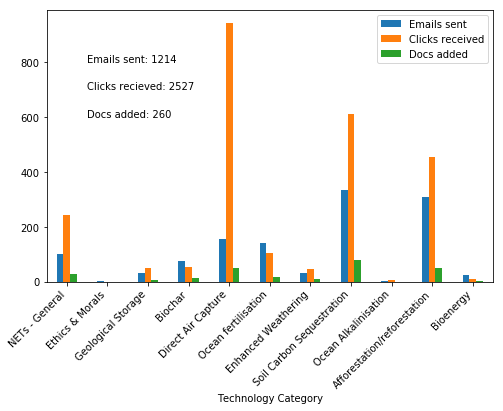

In [23]:
plt.rcParams["figure.figsize"] = [8,5]


pdf = bc.set_index('category__name')

pdf.plot.bar()

plt.text(0.5,800,"Emails sent: {}".format(pdf['a_emails_sent'].sum()))
plt.text(0.5,700,"Clicks recieved: {}".format(pdf['b_clicks_received'].sum()))
plt.text(0.5,600,"Docs added: {}".format(pdf['c_docs_added'].sum()))

plt.xlabel('Technology Category')

ls = ["Emails sent", "Clicks received", "Docs added"]

for i,t in enumerate(plt.legend().get_texts()):
    t.set_text(ls[i])
    
plt.xticks(rotation=45,ha="right")
plt.savefig('../plots/general/emails_responses.pdf',bbox_inches='tight') 
plt.savefig('../plots/general/emails_responses.png',bbox_inches='tight') 
plt.show()